In [1]:
# Imports

from contextlib import contextmanager
from datetime import datetime, timedelta
import sqlite3
import os

from zipline.api import order, order_target, record, symbol
from zipline.finance import commission, slippage
import zipline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


In [2]:
# Access Database

@contextmanager
def db(db_filename='stock.db'):
    
    conn = sqlite3.connect(os.path.join('..', 'data', db_filename), detect_types=sqlite3.PARSE_DECLTYPES|sqlite3.PARSE_COLNAMES)

    cur = conn.cursor()
    
    yield conn, cur
    
    conn.close()
    

In [3]:
# Custom Slippage Model

class TradeNearTheOpenSlippageModel(slippage.SlippageModel):

    def __init__(self, deviation=0.001):
        
        self.deviation = deviation

    def process_order(self, data, order):
        
        rand = min(np.abs(np.random.normal(0, self.deviation)), 1) # Generate a random value thats likely zero (zero=openprice)
        
        open_price = data.current(symbol(stock), 'open') 
        close_price = data.current(symbol(stock), 'close') 
        
        new_price = (close_price - open_price) * rand + open_price 
 
        return (new_price, order.amount)  


In [4]:
# Perfect Algo (aka already knows the future)

def predict_perfect(stock, date): # ~Perfect~ Predictor
    
    with db() as (conn, cur):
        
        cur.execute("SELECT date, adjclose FROM ticks WHERE stock=? AND date BETWEEN ? AND ? ORDER BY date DESC LIMIT 1", 
                    [stock, (date + timedelta(days=-5)).strftime('%Y-%m-%d'), (date + timedelta(days=0)).strftime('%Y-%m-%d')])
        before = cur.fetchall()[0]
        
        cur.execute("SELECT date, adjclose FROM ticks WHERE stock=? AND date BETWEEN ? AND ? ORDER BY date ASC LIMIT 1", 
                    [stock, (date + timedelta(days=1)).strftime('%Y-%m-%d'), (date + timedelta(days=5)).strftime('%Y-%m-%d')])
        after = cur.fetchall()[0]
        
        if after[1] > before[1]:
            return 1., 0.
        else:
            return 0., 1.
        

In [5]:
# Load Stuff

# import pickle, os
# with open(os.path.join('..', 'models', 'toke-tick.pkl'), 'rb') as toke_file:
#     toke = pickle.load(toke_file)

from keras.models import load_model
from gensim.models.doc2vec import Doc2Vec
model_type  = 'multiheadlineclf'
vec_model = Doc2Vec.load(os.path.join('..', 'models', 'doc2vec-' + model_type + '.doc2vec'))
model = load_model(os.path.join('..', 'models', 'media-headlines-ticks-' + model_type + '.h5'))


H:\Users\Shriv\Anaconda3\envs\tf-cpu\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
H:\Users\Shriv\Anaconda3\envs\tf-cpu\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [6]:
# Load Stuff Part 2

# from algoA import predict, correct_sign_acc, model_type
# from keras.models import load_model
# import keras.metrics
# keras.metrics.correct_sign_acc = correct_sign_acc
# model = load_model(os.path.join('..', 'models', 'media-headlines-ticks-' + model_type + '.h5'))

from algoB import predict


In [7]:
# Actual Algo
        
def predict_deep_nn(stock, date):
    
    # preds, prices = predict(stock, model, toke, current_date=date)
    
    preds = predict(stock, model, vec_model, current_date=date)
    
    return np.mean(preds[:, 0]), np.mean(preds[:, 1])


In [8]:
stock = 'INTC'

def initialize(context):
    context.set_commission(commission.PerShare(cost=0, min_trade_cost=1.0))
    context.set_slippage(TradeNearTheOpenSlippageModel())
    
def trade_logic(pred_func, context, data):
    
    date = data.current(symbol(stock), 'last_traded').to_datetime()
    
    up, down = pred_func(stock, date + timedelta(days=0))
    
    shares = context.portfolio.positions[symbol(stock)].amount
    
    if up > .6:
        
        max_shares = context.portfolio.cash // data.current(symbol(stock), 'price')
        if max_shares > 0:
            order(symbol(stock), max_shares)
            
    elif down > .6:
        
        if shares > 0:
            order_target(symbol(stock), 0)
        
    record(stock=data.current(symbol(stock), 'price'))
    record(shares=context.portfolio.positions[symbol(stock)].amount)
    
def handle_data_perfect(context, data):
    
    trade_logic(predict_perfect, context, data)
    
def handle_data_algo(context, data):

    trade_logic(predict_deep_nn, context, data)

start = pd.to_datetime('2018-01-01').tz_localize('US/Eastern')
end = pd.to_datetime('2018-05-8').tz_localize('US/Eastern')

perf_perfect = zipline.run_algorithm(start, end, initialize, 100, handle_data=handle_data_perfect)
perf_algo = zipline.run_algorithm(start, end, initialize, 100, handle_data=handle_data_algo)

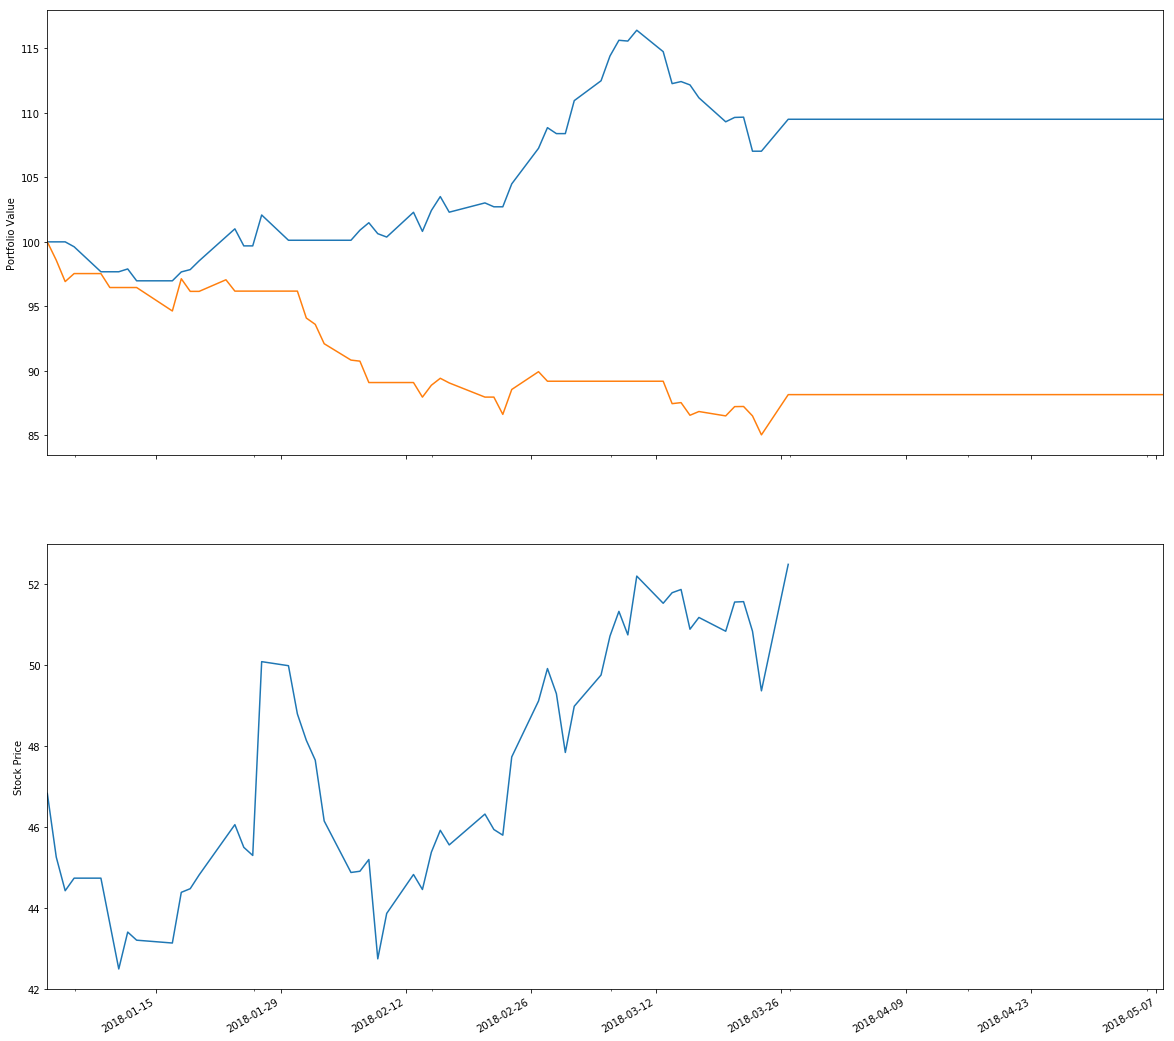

In [9]:
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 20), sharex=True)

perf_perfect.portfolio_value.plot(ax=ax1)
perf_algo.portfolio_value.plot(ax=ax1)
ax1.set_ylabel('Portfolio Value')
perf_perfect.stock.plot(ax=ax2)
ax2.set_ylabel('Stock Price')
plt.show()